<a href="https://colab.research.google.com/github/brooke57/TKR_FLT3_Drug_Discovery/blob/main/Drug_Discovery_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **TKR_FLT3 Drug Discovery Modeling**

In [ ]:
! pip install lazypredict

In [2]:
! pip install rdkit-pypi

     |████████████████████████████████| 22.3 MB 1.6 MB/s 


In [3]:
# Importing Relevant Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline

#import category_encoders as ce

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, plot_roc_curve, plot_confusion_matrix
from sklearn.metrics import confusion_matrix

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors

from sklearn.feature_selection import VarianceThreshold
from sklearn.inspection import permutation_importance

#from lazypredict.Supervised import LazyClassifier

from rdkit import Chem
from rdkit.Chem import AllChem, Draw

# import xgboost     # extreme gradient boosting


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df_cmbd = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Model_Dataset.csv')

In [6]:
df_cmbd.head()

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP879,PubchemFP880,mol_id,canon_smiles,MolWt,MolLogP,NumHDonors,NumHAcceptors,bioactivity_num,log_std_value
0,CHEMBL124660,1,1,1,1,0,0,0,0,0,...,0,0,CHEMBL124660,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...,562.715,5.03450,1,8,1,6.657577
1,CHEMBL330863,1,1,1,1,0,0,0,0,0,...,0,0,CHEMBL330863,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...,576.742,5.28050,1,8,1,6.892790
2,CHEMBL126699,1,1,1,1,0,0,0,0,0,...,0,0,CHEMBL126699,COc1cc2c(N3CCN(C(=O)Nc4ccc(C#N)cc4)CC3)ncnc2cc...,543.672,4.50748,1,8,0,5.056011
3,CHEMBL445636,1,1,1,1,0,0,0,0,0,...,0,0,CHEMBL445636,COc1cc2c(N3CCN(C(=O)Nc4ccc(C#N)cc4)CC3)ncnc2cc...,543.672,4.36498,1,8,0,5.718967
4,CHEMBL124035,1,1,1,1,0,0,0,0,0,...,0,0,CHEMBL124035,COCCOc1cc2ncnc(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC...,495.580,3.80490,1,8,1,6.346787


In [7]:
df_cmbd.set_index('Name', inplace=True)

In [8]:
drop = ['mol_id', 'canon_smiles', 'MolWt', 'MolLogP', 'NumHDonors', 'NumHAcceptors', 'log_std_value', 'log_std_value', 'bioactivity_num']

In [9]:
# Features dataframe
X = df_cmbd.drop(drop, axis=1)
X.head()

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
Name,,,,,,,,,,,,,,,,,,,,,
CHEMBL124660,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
CHEMBL330863,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
CHEMBL126699,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
CHEMBL445636,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
CHEMBL124035,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [10]:
X.shape

(2844, 881)

In [11]:
# Target dataframe
y = df_cmbd['bioactivity_num']

In [12]:
y.shape

(2844,)

### **Train Test Split**

In [13]:
# Setting aside 10% of data for a holdout set to be tested on final model
X_train, X_hold, y_train, y_hold, ind_train, ind_hold = train_test_split(X,y, 
                                                                         X.index,
                                                                         test_size=0.1, random_state=42)

In [14]:
# Train test split for training and testing data
X_tr, X_te, y_tr, y_te, ind_tr, ind_te = train_test_split(X_train, y_train,
                                                          X_train.index,
                                                          test_size=0.2,
                                                          random_state=42)

In [15]:
X_tr.shape

(2047, 881)

In [16]:
y_tr.shape

(2047,)

### **Remove Low Variance Features**

In [17]:
select = VarianceThreshold(threshold = (0.8 * (1 - 0.8)))
select.fit(X_tr)

cols = select.get_support(indices=True)
X_tr = X_tr[X_tr.columns[cols]]
X_te = X_te[X_te.columns[cols]]
X_hold = X_hold[X_hold.columns[cols]]

In [18]:
X_train.to_csv('/content/drive/MyDrive/Colab Notebooks/data/X_features.csv')

In [19]:
# Making sure that X_tr has the same number of rows as y_tr
x_tr_shape = X_tr.shape
y_tr_shape = y_tr.shape
print(f'X_tr shape: {x_tr_shape}')
print(f'y_tr shape: {y_tr_shape}')

X_tr shape: (2047, 149)
y_tr shape: (2047,)


In [20]:
# Making sure that X_te has the same number of rows as y_te
x_te_shape = X_te.shape
y_te_shape = y_te.shape
print(f'X_te shape: {x_te_shape}')
print(f'y_te shape: {y_te_shape}')

X_te shape: (512, 149)
y_te shape: (512,)


In [21]:
# Making sure that X_hold has the same number of rows as y_hold
x_hold_shape = X_hold.shape
y_hold_shape = y_hold.shape
print(f'X_hold shape: {x_hold_shape}')
print(f'y_hold shape: {y_hold_shape}')

X_hold shape: (285, 149)
y_hold shape: (285,)


In [22]:
def evaluate(model, x_train, y_train, x_test, y_test):

  y_train_preds = model.predict(x_train)
  y_test_preds = model.predict(x_test)

  train_acc = str(np.round(accuracy_score(y_train, y_train_preds)*100, 2)) + '%'
  train_pre = str(np.round(precision_score(y_train, y_train_preds)*100, 2)) + '%'
  train_f1 = str(np.round(f1_score(y_train, y_train_preds)*100, 2)) + '%'

  test_acc = str(np.round(accuracy_score(y_test, y_test_preds)*100, 2)) + '%'
  test_pre = str(np.round(precision_score(y_test, y_test_preds)*100, 2)) + '%'
  test_f1 = str(np.round(f1_score(y_test, y_test_preds)*100, 2)) + '%'

  array = [[train_acc, train_pre, train_f1],
           [test_acc, test_pre, test_f1]]

  df = pd.DataFrame(array, columns=['Accuracy', 'Precision', 'F1 Score'])
  df.index = ['Training', 'Testing']

  plot_confusion_matrix(model, x_test, y_test, cmap='plasma', normalize='true')

  return df

## **Using Lazy Predict Library to see Best Classifiers**

In [ ]:
lc = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None, random_state=42)
mod_train, preds_train = lc.fit(X_tr, X_te, y_tr, y_te)
mod_train

NameError: ignored

## **Decision Tree Classifier**

In [ ]:
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt.fit(X_tr, y_tr)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


,Accuracy,Precision,F1 Score
Training,98.63%,99.49%,98.83%
Testing,84.77%,87.8%,86.6%


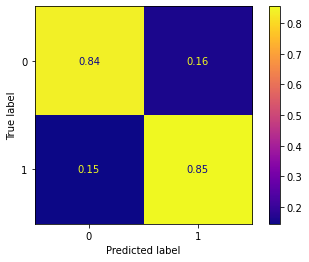

In [ ]:
evaluate(dt, X_tr, y_tr, X_te, y_te)

## **Experimenting with Max depth**

In [ ]:
dt.get_depth()

17

In [ ]:
# Setting up parameter grid for GridSearchCV
grid = {'max_depth': [5, 10, 15],
        'class_weight': ['balanced', None]
        }

In [ ]:
dt2 = DecisionTreeClassifier(random_state=42)
search = GridSearchCV(dt2, grid, scoring = ['f1', 'precision'], refit='f1')

In [ ]:
output = search.fit(X_tr, y_tr)

In [ ]:
output.best_params_

{'class_weight': 'balanced', 'max_depth': 10}

In [ ]:
dtc_best_est = output.best_estimator_
dtc_best_est.fit(X_tr, y_tr)


DecisionTreeClassifier(class_weight='balanced', max_depth=10, random_state=42)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


,Accuracy,Precision,F1 Score
Training,95.26%,96.78%,95.93%
Testing,85.94%,89.12%,87.59%


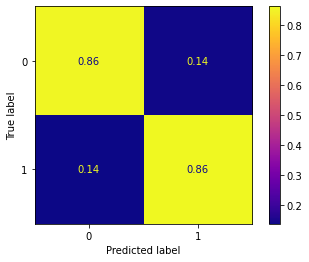

In [ ]:
evaluate(dtc_best_est, X_tr, y_tr, X_te, y_te)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


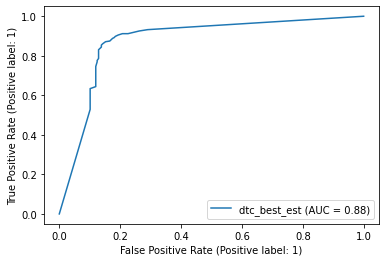

In [ ]:
plot_roc_curve(dtc_best_est, X_te, y_te, name='dtc_best_est')

## **Random Forest Classifier**

In [ ]:
first_ran = RandomForestClassifier(class_weight='balanced', random_state=42)
first_ran.fit(X_tr, y_tr)

RandomForestClassifier(class_weight='balanced', random_state=42)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


,Accuracy,Precision,F1 Score
Training,98.63%,99.0%,98.83%
Testing,90.62%,89.21%,92.13%


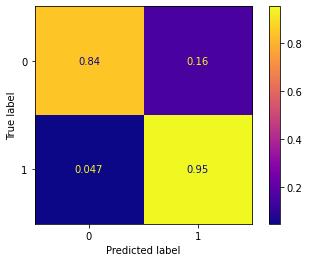

In [ ]:
evaluate(first_ran, X_tr, y_tr, X_te, y_te)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


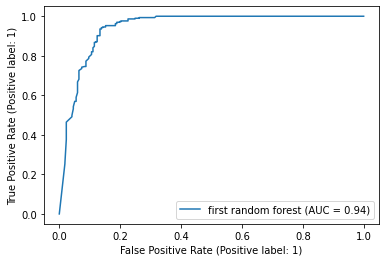

In [ ]:
plot_roc_curve(first_ran, X_te, y_te, name='first random forest');

false positive: saying that a compound is active towards target protein when it isn't
false negative: saying that a compound isn't active towards the target protein when it is
for this problem, it is more important to minimize false positives, or to maximize precision

### **First Random Forest Evaluation**
In this first random forest model, it is clear that the model is performing well; training metrics are 98% or above, and testing metrics are 89% or above. This  The ROC_AUC score is also high, at 94%. However, the model is overfitting by about ten percentage points. In the next iteration, I will perform a grid search to find a set of parameters that will hopefully decrease overfitting.

## **Second Random Forest Iteration**

In order to set accurate grid search parameters for the random forest parameters of interest, I want to get a good idea of the range of parameters in the first random forest iteration.

In [ ]:
# Looking at range of values for leaf nodes
leaf_nodes = []
for est in first_ran.estimators_:
  leaf_nodes.append(est.tree_.n_leaves)
leaf_nodes
maxLeafNode = max(leaf_nodes)
minLeafNode = min(leaf_nodes)
print(maxLeafNode)
print(minLeafNode)

356
278


In [ ]:
# Looking at range of values for max depths
depths = []
for est in first_ran.estimators_:
  depths.append(est.tree_.max_depth)
depths
max_depth = max(depths)
min_depth = min(depths)
print(max_depth)
print(min_depth)

25
16


### **Explanation of Random Forest GridSearch Parameters:**
**max_features:** Including a proportion of all of the possible features can help make sure that the individual trees are not correlated with each other. So, I will test out a variety of equations which yield different feature proportions.\
**max_samples:** Including only a proportion of the samples in each tree can help reduce overfitting, so I will include a range of values for this parameter. \
**max_depth:** setting a max_depth can be key to preventing overfitting, because it prevents a tree from splitting until all nodes in training data are pure by stopping the splitting once a certain depth is reached. This results in a model overfit to training data.\
**max_leaf_nodes:** Similar to max_depth, this parameter prevents the decision tree from splitting until all nodes are pure, this time by stopping the splitting once the trees have reached a certain number of total nodes.

In [23]:
# Setting up parameter grid for GridSearchCV
rf_grid = {'max_features': ['auto', 'sqrt', 'log2',None],
               'max_samples': [0.5, 0.8, 1,],
               'max_depth': [10, 17, 25],
               'max_leaf_nodes': [150, 250, 350]
               }

In [24]:
rand_grid = RandomForestClassifier(class_weight = 'balanced', random_state=42)
rand_search = GridSearchCV(rand_grid, rf_grid, scoring = ['f1', 'precision'], refit='f1')

In [25]:
rand_output = rand_search.fit(X_tr, y_tr)

In [26]:
rand_output.best_params_

{'max_depth': 25,
 'max_features': 'log2',
 'max_leaf_nodes': 250,
 'max_samples': 0.8}

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


,Accuracy,Precision,F1 Score
Training,97.95%,98.41%,98.25%
Testing,91.21%,89.31%,92.66%


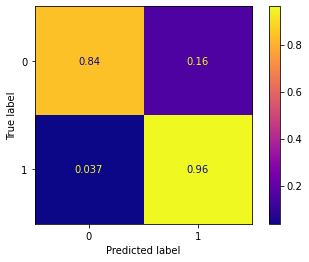

In [27]:
evaluate(rand_output, X_tr, y_tr, X_te, y_te)

After searching for, finding, and using the parameters found by GridSearch, testing accuracy has increased slightly, resulting in slightly decreased overfitting.

## **Experimenting with min_samples_split**

Fine-tuning the min_samples_split parameter is another way of reducing overfitting. It stops the trees from splitting when a node has less than a designated number of samples.

In [ ]:
split_grid = {'min_samples_split': [5, 10, 20, 50, 100]}

In [ ]:
rf_split = RandomForestClassifier(class_weight = 'balanced', random_state=42,
                                  max_depth = 25, max_features = 'log2',
                                  max_leaf_nodes = 250, max_samples = 0.8)
split_search = GridSearchCV(rf_split, split_grid, scoring = ['f1', 'precision'], refit='f1')

In [ ]:
split_output = split_search.fit(X_tr, y_tr)

In [ ]:
split_output.best_params_

{'min_samples_split': 5}

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


,Accuracy,Precision,F1 Score
Training,95.7%,95.73%,96.36%
Testing,91.21%,89.31%,92.66%


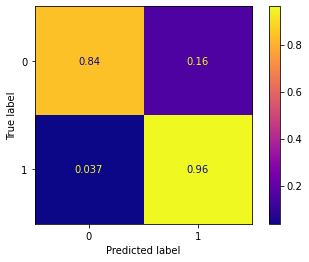

In [ ]:
evaluate(split_output, X_tr, y_tr, X_te, y_te)

After incorporating the results of both GridSearches, testing metrics stayed the same but training metrics decreased, which resulted in an overall decrease in overfitting compared to the last model. However, since training scores went down and I don't want to overfit the training or testing data, I will not incorporate min_samples_split in future iterations.

## **K-Nearest Neighbors Model**

In [ ]:
knn = KNeighborsClassifier()

In [ ]:
cross_validate(knn, X_tr, y_tr, return_train_score = True)

{'fit_time': array([0.04899144, 0.03611135, 0.03535295, 0.03675318, 0.03650331]),
 'score_time': array([0.29878664, 0.26991916, 0.2771709 , 0.267694  , 0.27452755]),
 'test_score': array([0.86097561, 0.87560976, 0.88508557, 0.86797066, 0.85819071]),
 'train_score': array([0.90226023, 0.89981674, 0.91330891, 0.90781441, 0.90598291])}

In [ ]:
knn_grid = {'n_neighbors': [5, 10, 15, 20],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'p': [1,2,3]}

In [ ]:
knn_search = GridSearchCV(knn, knn_grid, scoring = ['f1', 'precision'], refit='f1')

In [ ]:
knn_output = knn_search.fit(X_tr, y_tr)

In [ ]:
knn_output.best_params_

{'algorithm': 'auto', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


,Accuracy,Precision,F1 Score
Training,98.63%,99.49%,98.83%
Testing,89.45%,88.01%,91.18%


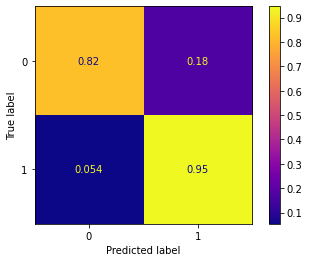

In [ ]:
evaluate(knn_search, X_tr, y_tr, X_te, y_te)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


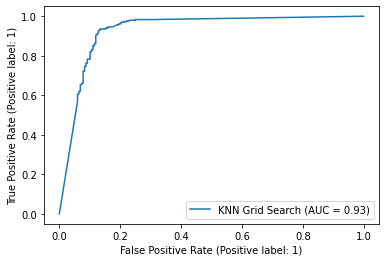

In [ ]:
plot_roc_curve(knn_search, X_te, y_te, name='KNN Grid Search');

## **Evaluating the Best Model on the Holdout Set**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


,Accuracy,Precision,F1 Score
Training,97.95%,98.41%,98.25%
Testing,88.77%,85.09%,89.54%


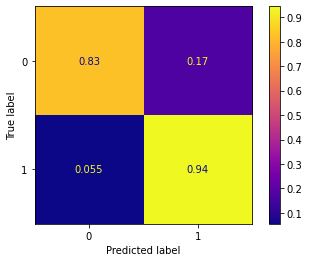

In [ ]:
evaluate(rand_output, X_tr, y_tr, X_hold, y_hold)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


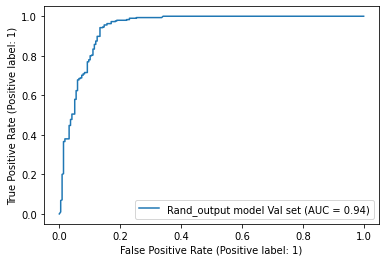

In [ ]:
plot_roc_curve(rand_output, X_te, y_te, name='Rand_output model Val set');

## **Permutation Feature Importance**

In [28]:
res = permutation_importance(
    rand_output, X_hold, y_hold, n_repeats=10, random_state=42)
sorted_index = res.importances_mean.argsort()


In [29]:
pfi_df = pd.DataFrame(res.importances_mean[sorted_index], columns = ['Feature Importance'])

In [30]:
pfi_df.set_index(X_hold.columns[sorted_index], inplace=True)

In [31]:
pfi_df.sort_values(by = 'Feature Importance', ascending=False, inplace = True)

In [32]:
pfi_df

,Feature Importance
PubchemFP716,0.007917
PubchemFP23,0.007480
PubchemFP491,0.007127
PubchemFP450,0.007110
PubchemFP261,0.006673
...,...
PubchemFP606,-0.001761
PubchemFP654,-0.002134
PubchemFP385,-0.002469
PubchemFP689,-0.002519


In [33]:
pfi_df.describe()

,Feature Importance
count,149.000000
mean,0.002040
std,0.002279
min,-0.002876
25%,0.000358
50%,0.001811
75%,0.003267
max,0.007917


In [34]:
pfi_df_median = pfi_df.describe().loc['50%'][0]

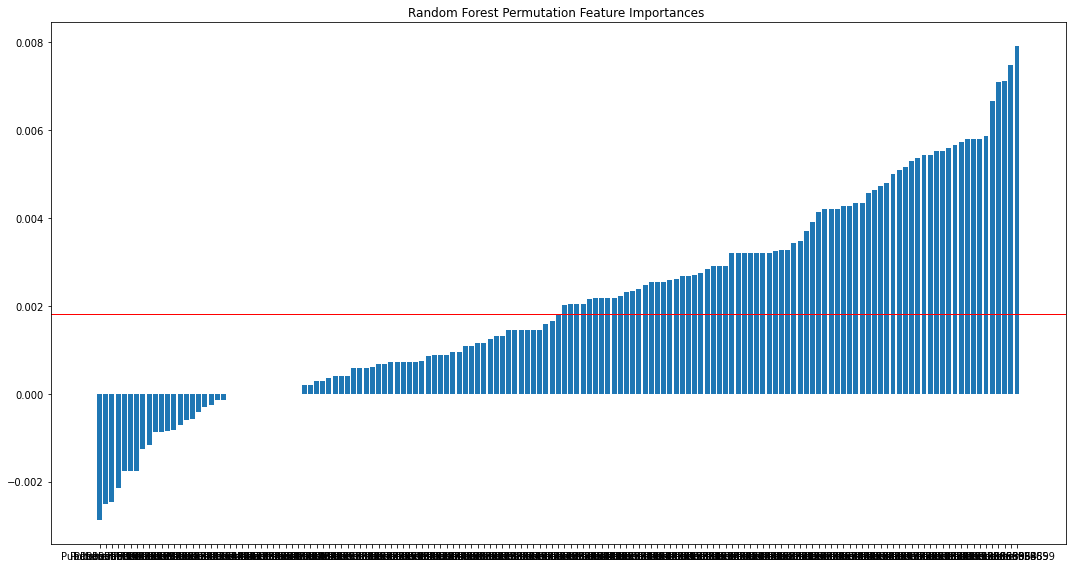

In [35]:
fig, ax = plt.subplots(figsize=(15,8))

x_ticks = np.arange(0, len(pfi_df.index))
ax.bar(x_ticks, res.importances_mean[sorted_index])
ax.set_xticks(x_ticks)
ax.set_xticklabels(pfi_df.index)
ax.set_title("Random Forest Permutation Feature Importances ")
plt.axhline(y=pfi_df_median ,linewidth=1, color='r')
fig.tight_layout()
plt.show()

In [36]:
# Getting the top 10% permutation feature importances
pfi_grd_search = []
for x in range(len(pfi_df['Feature Importance'][:15])):
  pfi_grd_search.append(pfi_df.index[x])
pfi_grd_search

['PubchemFP716',
 'PubchemFP23',
 'PubchemFP491',
 'PubchemFP450',
 'PubchemFP261',
 'PubchemFP672',
 'PubchemFP569',
 'PubchemFP192',
 'PubchemFP186',
 'PubchemFP439',
 'PubchemFP388',
 'PubchemFP652',
 'PubchemFP435',
 'PubchemFP373',
 'PubchemFP443']

In [51]:

FP716 = 'Cc1ccc(N)cc1'
FP23 = '1 F'
FP491 = 'C-N:C-[#1]'
FP450 = 'C(-N)(=N)'
FP261 = '4 aromatic rings' # Not a particular structure, just a molecule with four aromatic rings 
FP672 = 'O=C-C=C-[#1]'
FP569 = 'N-C-C-N'
FP192 = '3 any ring size 6' # Not a particular structure, but a molecule that contains three of any kind of ring each with six atoms
FP186 = '2 saturated or aromatic carbon-only ring size 6' # Not a particular structure, but contains the features specified
FP439 = 'C(-C)(-N)(=O)'


fpi_fp_randSearch = [FP716, FP491, FP450, FP672, FP569, FP439]

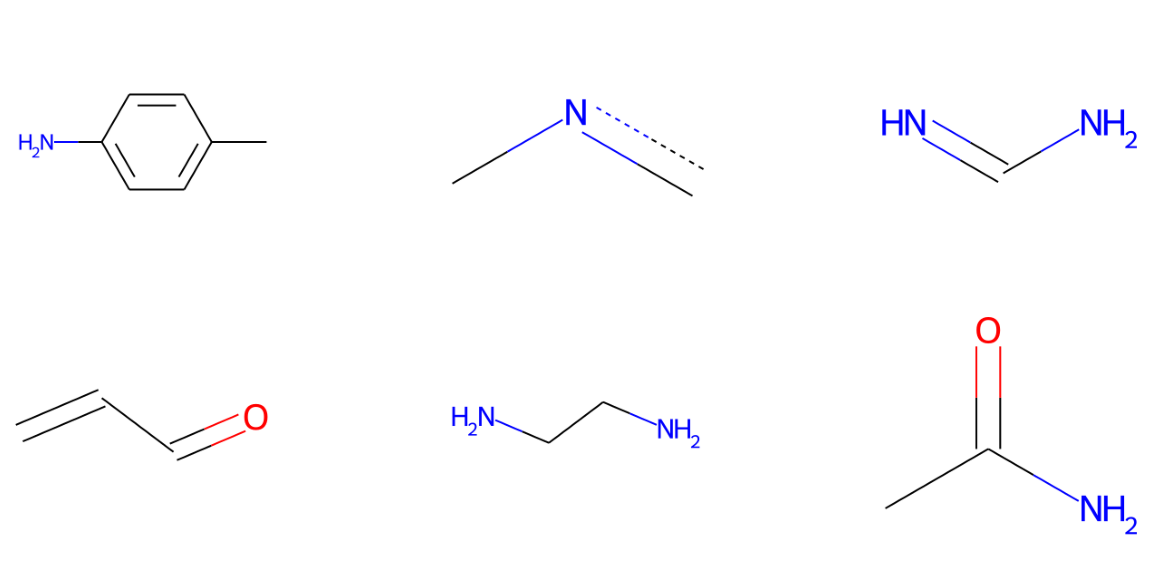

In [55]:
fig, axes = plt.subplots(2, 3, figsize=(20,8), sharex=True, sharey=True)
axrs = axes.reshape(-1)

for a in axrs:
  a.set_axis_off()

for i, x in enumerate(fpi_fp_randSearch):
  mol = Chem.MolFromSmiles(x)
  AllChem.Compute2DCoords(mol)
  structure = Draw.MolToImage(mol)
  axrs[i].set_axis_on()
  axrs[i].imshow(structure)
  axrs[i].axis('off')

plt.tight_layout()
plt.show()